# Backpropagation from scratch

## Introduction
The goal of the project is to train neural networks using a backpropagation algorithm.
This algorithm is used to improve the accuracy of the neural network and make it capable of self-learning. 
In order to minimize the cost function, we will use the gradient descent method. This method consists of two steps: to calculate gradients of the loss/error function and then update existing parameters in response to the gradients. This process is repeated until the loss function minima is reached.

In [205]:
import numpy as np  # basic numeric library for python
import pickle  # used to save the traned model (useful to perform experiments without re-training it every time)
import matplotlib.pyplot as plt  # basic python plotting library
import json  # used to save training history values
from tqdm import tqdm  # use to create a progress bar
from matplotlib.pyplot import figure
import matplotlib


matplotlib.rcParams["figure.figsize"] = [14, 8]

First we initialize the model with weights as small random values and biases as zero.
We define function forward to pass our inputs through the network and obtain output predictions. We calculate the outputs for each neuron as we go through each layer of our network. The neurons on the next layer get all of the outputs from the previous layer as inputs.
We defined function backward to compute the gradient at the prediction layer and use it to update the weights of our network in order to predict correctly the target output value. The difference between the expected and forward propagated outputs from the network is calculated as error. These errors are then propagated backwards through the network, from the output layer to the hidden layer, updating weights as they go.
note: In backpropagation we have to use activation function which is differentiable.

In [190]:
class Layer:
    def __init__(self, input_size: int, output_size: int):
        self.weights = np.random.rand(input_size, output_size)

    def __call__(self, x: np.ndarray):  # activation function
        return 1 / (1 + np.exp(-np.einsum("ji,j->i", self.weights, x)))  # sigmoid


class NN:
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        lr: float = 0.7,  # learning rate using during the update phase
        regularization: float = 0.0001,  # determines how important is that weights should be small
    ):
        fc1 = Layer(
            input_size + 1, hidden_size + 1
        )  # +1 adding extra node for the bias
        fc2 = Layer(hidden_size + 1, output_size + 1)
        self.layers = [fc1, fc2]
        self.cum_deltas = [
            np.zeros((input_size + 1, hidden_size + 1)),
            np.zeros((hidden_size + 1, output_size + 1)),
        ]
        self.m = 0
        self.lr = lr
        self.regularization = regularization

    # function forward which implements the forward propagation and return
    #  the array which is used as input for the following layer
    def forward(self, x: np.ndarray, y=None, verbose=False):
        x = np.concatenate((x, [1]))
        y = np.concatenate((y, [1]))
        a2 = self.layers[0](x)
        a3 = self.layers[1](a2)
        delta3 = a3 * (1 - a3) * (a3 - y)
        delta2 = a2 * (1 - a2) * np.einsum("ij,j->i", self.layers[1].weights, delta3)
        deltas = [delta2, delta3]
        all_a = [x, a2, a3]
        for l, cum_delta in enumerate(self.cum_deltas):
            self.cum_deltas[l] += np.einsum("i,j->ij", all_a[l], deltas[l])

        if verbose:
            print(f"{a2.shape=}")
            print(f"{a3.shape=}")
            print(f"{delta3.shape=}")
            print(f"{self.cum_deltas=}")
            print(f"{delta2.shape=}")
        self.m += 1
        return [a3[:-1], a2]

    # First we calculate error for each output neuron which after we propagate
    # backwards through the network.
    # Error signal calculated for each neuron is stored with the name delta.
    def backward(self):
        for l, cum_delta in enumerate(self.cum_deltas):
            mask = np.einsum(  # we shouldn't add the regularization coefficient to thee bias
                "i,j->ji",
                (np.arange(cum_delta.shape[1]) != (cum_delta.shape[1] - 1)).astype(
                    "float"
                ),
                np.zeros(cum_delta.shape[0]) + 1,
            )
            params = (
                1
                / self.m
                * (cum_delta - self.regularization * self.layers[l].weights * mask)
            )
            self.layers[l].weights = (
                self.layers[l].weights - self.lr * params
            )  # update weights
            cum_delta[:, :] = 0
        self.m = 0

    def __call__(self, x: np.ndarray):
        return self.forward(x)

## Training

Our network is trained using stochastic gradient descent.
This entails exposing a training dataset to the network several times and forward propagating the inputs, backpropagating the error, and updating the network weights for each row of data.
Here we have implemented a version of mini-batch gradient descent. With respect to vanilla gradient descent this algorithm introductes more stochaststicity and threfore converges more reliably on a solution. This because the descent has lesser chance to get stuck in a local minima. The ammount of stochasticity we want can be controlled by the `batch_size` hyperparameter. Naturally, too much randomness and the network might not converge to the solution.

In [208]:
def train(
    verbose=False,  # Print out the loss as the training proceeds
    save=False,  # Save model and history
    epochs=10000,  # number of times we iterate through the entire dataset
    lr: float = 0.9,
    regularization=0.0001,
    batch_size=2,  # how many xs do we look at before computing the 'backward'
):
    nn = NN(8, 3, 8, lr=lr, regularization=regularization)
    xs = np.identity(8)
    history = []
    for epoch in range(epochs):
        indices = np.arange(len(xs))
        np.random.shuffle(indices)
        xs = xs[indices]
        n_batches = int(np.floor(len(xs) / batch_size))
        loss = 0
        last_i = 0
        for _ in range(n_batches):
            batch = xs[last_i : last_i + batch_size]
            for x in batch:
                pred_y = nn.forward(x, x)[0]
                loss += 1 / 2 * ((pred_y - x) ** 2).sum()
            nn.backward()
        if verbose and epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss {loss}")
        history.append(loss)
    if save:
        with open("nn.pickle", "wb") as f:
            pickle.dump(nn, f)
        with open("history.json", "w") as f:
            json.dump(history, f)
    if verbose:
        pred_y = np.around(nn.forward(xs[0], xs[0])[0], 2)
        print(f"\nx={xs[0]}\npredicted={pred_y}")
    return history

In [209]:
training_history = train(verbose=True, save=True)

Epoch: 0, loss 15.862918700264162
Epoch: 100, loss 3.677854290110744
Epoch: 200, loss 1.8237016888391144
Epoch: 300, loss 0.5854518846448935
Epoch: 400, loss 0.2349684246680056
Epoch: 500, loss 1.402975357760837
Epoch: 600, loss 1.3203145189676737
Epoch: 700, loss 0.5665314336929977
Epoch: 800, loss 0.751882733425399
Epoch: 900, loss 0.20435721692530812
Epoch: 1000, loss 0.11011013187170655
Epoch: 1100, loss 0.1388827336128432
Epoch: 1200, loss 0.07080758100829215
Epoch: 1300, loss 0.050405966492603094
Epoch: 1400, loss 0.05144861268528159
Epoch: 1500, loss 0.06054390353977197
Epoch: 1600, loss 0.04772334229235155
Epoch: 1700, loss 0.03119937315404503
Epoch: 1800, loss 0.04073715092527403
Epoch: 1900, loss 0.02945612359170044
Epoch: 2000, loss 0.017483343575439708
Epoch: 2100, loss 0.01697779478458082
Epoch: 2200, loss 0.016763236867296763
Epoch: 2300, loss 0.01299143336920739
Epoch: 2400, loss 0.01915565114198559
Epoch: 2500, loss 0.014906767795578507
Epoch: 2600, loss 0.0092298193952

In [193]:
def plot_training_history():
    with open("nn.pickle", "rb") as f:
        nn = pickle.load(f)
    with open("history.json", "r") as f:
        history = np.array(json.load(f))
    plt.plot(range(len(history)), history)
    plt.ylabel("Loss (square error)")
    plt.xlabel("Epoch")
    plt.title("Training History")
    # plt.show()
    plt.savefig("history.png")

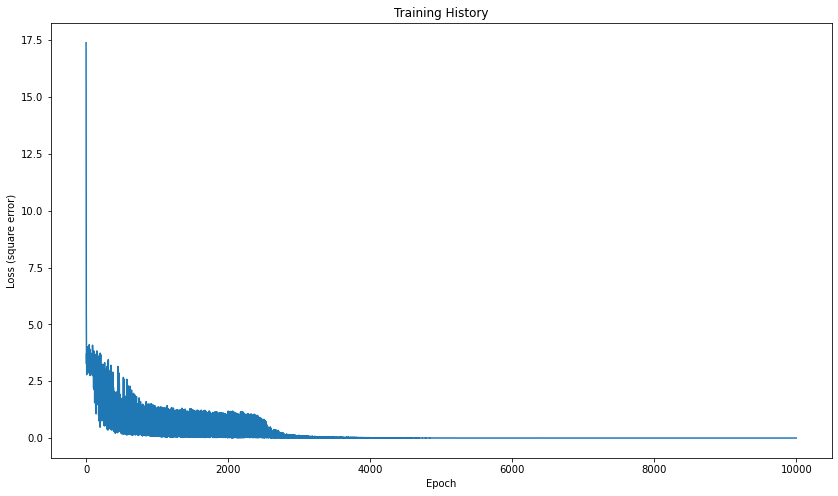

In [194]:
plot_training_history()

## Testing convergence

Does the model converge every time or only when we get the initial (random) weights right? To test it we train the model 10 times and theck how many times it actually converge and to which value.

In [195]:
def test_convergence(n_times=10):
    histories = []
    plt.xlabel("Epoch")
    plt.ylabel("Los (square difference)")
    last_losses = []
    for _ in tqdm(range(n_times)):
        history = train()
        plt.plot(range(len(history)), np.array(history))
        histories.append(history)
        if len(history) == 0:
            print(history)
        last_losses.append(history[-1])
    losses = np.array(last_losses)
    print(f"Mean absolute difference: {np.mean(np.abs(losses - np.mean(losses)))}")
    plt.title(f"Convergence test with {n_times} repeated trainings")

    with open("histories.json", "w") as f:
        json.dump(histories, f)
    plt.show()
    plt.savefig("histories.png")
    return np.mean(np.abs(losses - np.mean(losses)))

100%|██████████| 10/10 [00:32<00:00,  3.26s/it]

Mean absolute difference: 4.251127657432929e-05


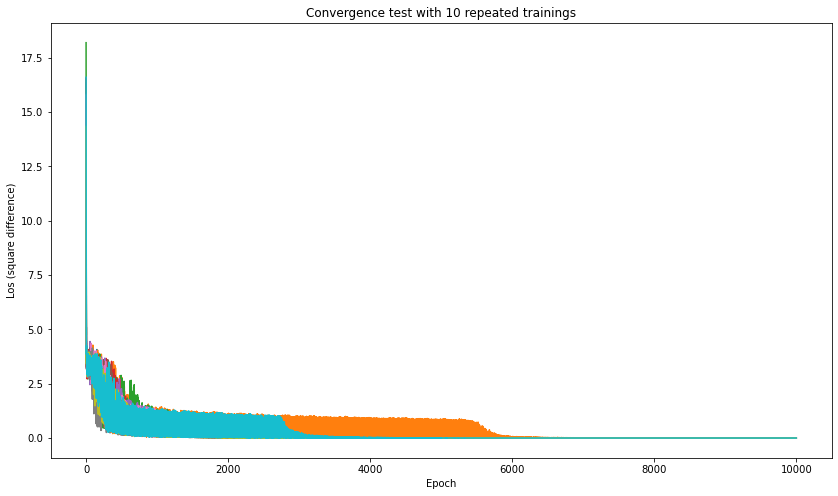

Mean absolute difference: 4.251127657432929e-05


<Figure size 1008x576 with 0 Axes>

In [196]:
md = test_convergence()
print(f"Mean absolute difference: {md}")

Above you will notice the mean absolute difference between the converged values. The model converges reliably.

## Optimizing Hyperparameters

The values of the learning rate, regularization and batch size parameters used in the training above were selected just by trial and error.
A much better way is to use an evolutionary algorithm to optimize those two hyperparameters.
Here we have implemented a genetic algorithm with random mutation and cross-breeding.
The evolutionary history is summarized in the plot below. Notice the similarity between the hyperparameters found by our algorithm and the ones found by naive trial and error.

In [197]:
genome_template = (
    (0.0, 1.0),  # LR: min and max value
    (0.0, 0.5),  # Regularization coefficient
    (1, 8),  # Batch size
)


def mate(g1: np.ndarray, g2: np.ndarray) -> np.ndarray:
    return mutate_genome(
        np.array(
            [
                gene1 if np.random.rand() > 0.5 else gene2
                for (gene1, gene2) in zip(g1, g2)
            ]
        )
    )


def rand(a, b):
    return np.random.rand() * (b - a) + a


def get_random_genomes(count: int) -> np.ndarray:
    return np.array(
        [np.array([rand(*g) for g in genome_template]) for _ in range(count)]
    )


def mutate_feature(original_value, i: int, mutation_impact: float):
    min_val, max_val = genome_template[i]
    x_range = mutation_impact * (max_val - min_val)
    new_val = np.clip(
        rand(original_value - x_range, original_value + x_range), min_val, max_val
    )
    return new_val


def mutate_genome(  # implement random mutation
    genome: np.ndarray, mutation_rate: float = 0.1, mutation_impact: float = 0.5
) -> np.ndarray:
    return np.array(
        [
            feature
            if np.random.rand() > mutation_rate
            else mutate_feature(feature, i, mutation_impact)
            for (i, feature) in enumerate(genome)
        ]
    )


def get_survivors(
    population: np.ndarray, fitnesses: np.ndarray, percent: float = 0.3
):  # select the best 30% genomes
    sorting_idxs = np.argsort(fitnesses)
    cutoff = round(len(population) * percent)
    return (population[sorting_idxs][:cutoff], fitnesses[sorting_idxs][:cutoff])


def get_fitnesses(
    population: np.ndarray,
):  # train a model with the parameters contained in the genome, then get the last loss obtained during training
    return np.array(
        [train(False, 10000, g[0], g[1], int(g[2]))[-1] for g in population]
    )


def get_offspring(population: np.ndarray):
    idxs1 = np.arange(len(population))
    np.random.shuffle(idxs1)
    idxs2 = np.arange(len(population))
    np.random.shuffle(idxs2)
    mates1 = population[idxs1]
    offspring = np.array(
        [mate(g1, g2) for (g1, g2) in zip(population[idxs1], population[idxs2])]
    )
    return offspring


def get_evolved_hyperparameters(population_size: int, generations: int):
    population = get_random_genomes(population_size)  # initialize population randomly
    print(f"Initial (random) population:\n{population}")
    history = []
    for generation in range(generations):
        fitnesses = get_fitnesses(population)  # evaluate the genomes
        survivors = get_survivors(population, fitnesses)[0]  # select survivors
        offspring = get_offspring(survivors)  # create survivors' offspring
        new_random = get_random_genomes(
            population_size - 2 * len(survivors)
        )  # generate some new random individuals
        sorting_idxs = np.argsort(fitnesses)
        best_fitness = fitnesses[sorting_idxs][0]
        best_genome = population[sorting_idxs[0]]
        history.append((best_fitness, best_genome))
        print(
            f"Generation:{generation}\nBest fitness: {best_fitness}\nBest genome: {best_genome}\n"
        )
        population = np.concatenate(
            (survivors, offspring, new_random)
        )  # generate new population
    return history

In [198]:
generations = 20
evolution_history = get_evolved_hyperparameters(
    population_size=10, generations=generations
)

Initial (random) population:
[[0.99642197 0.15911095 5.78603502]
 [0.19412774 0.14000703 2.89493076]
 [0.96734081 0.34398986 6.4250437 ]
 [0.15315976 0.02957911 6.15197592]
 [0.23927869 0.30019526 7.71433138]
 [0.90779682 0.3519905  4.35296505]
 [0.88531162 0.38221881 5.8160633 ]
 [0.76400318 0.02418232 7.18391739]
 [0.95303012 0.10882794 6.75556337]
 [0.29383499 0.47329863 1.70499325]]


/tmp/ipykernel_196776/3855175430.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-np.einsum("ji,j->i", self.weights, x)))  # sigmoid
/tmp/ipykernel_196776/3855175430.py:72: RuntimeWarning: overflow encountered in subtract
  self.layers[l].weights - self.lr * params


Generation:0
Best fitness: 1.0
Best genome: [0.76400318 0.02418232 7.18391739]

Generation:1
Best fitness: 1.0000944431448127
Best genome: [0.15315976 0.02957911 6.15197592]

Generation:2
Best fitness: 1.5
Best genome: [0.15315976 0.02957911 6.15197592]

Generation:3
Best fitness: 0.5001304824591565
Best genome: [0.15315976 0.02957911 6.15197592]

Generation:4
Best fitness: 0.014560107517391242
Best genome: [9.89500922e-01 1.87432095e-04 7.39333859e+00]

Generation:5
Best fitness: 0.2887486214482977
Best genome: [9.89500922e-01 1.87432095e-04 7.39333859e+00]

Generation:6
Best fitness: 0.28868876214657874
Best genome: [9.89500922e-01 1.87432095e-04 7.39333859e+00]

Generation:7
Best fitness: 0.01676437662396154
Best genome: [9.89500922e-01 1.87432095e-04 7.39333859e+00]

Generation:8
Best fitness: 0.012252237250945281
Best genome: [9.89500922e-01 1.87432095e-04 5.71714713e+00]

Generation:9
Best fitness: 0.008608426844711298
Best genome: [9.89500922e-01 1.87432095e-04 5.71714713e+00]



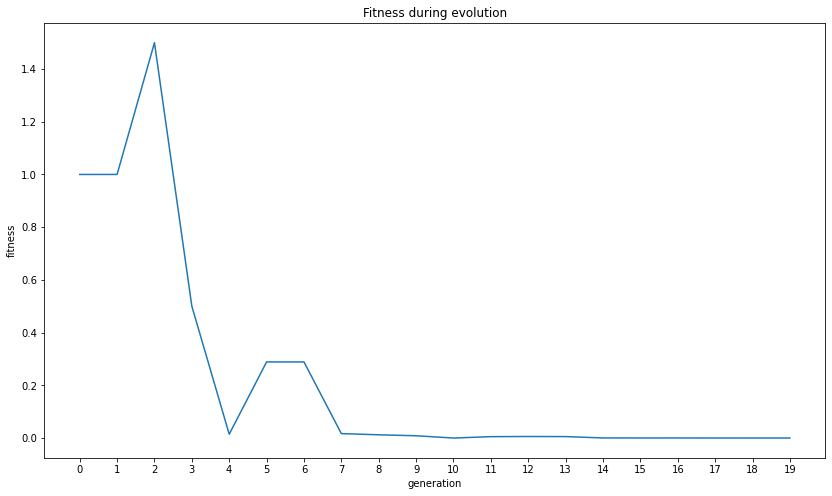

In [199]:
plt.plot(
    np.arange(len(evolution_history)),
    [h[0] for h in evolution_history],
    label="fitness",
)
plt.xticks(np.arange(generations))
plt.xlabel("generation")
plt.ylabel("fitness")
plt.title("Fitness during evolution")
plt.show()

As one can see, the algorithm is quite successful: the fitness goes down very quiclky.

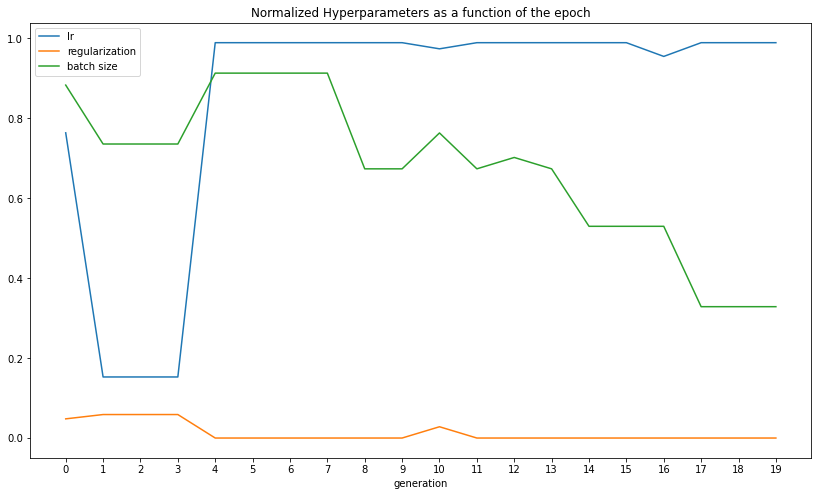

In [200]:
def normalize(x, i):
    a, b = genome_template[i]
    return (x - a) / (b - a)


plt.plot(
    np.arange(len(evolution_history)),
    [normalize(h[1][0], 0) for h in evolution_history],
    label="lr",
)
plt.plot(
    np.arange(len(evolution_history)),
    [normalize(h[1][1], 1) for h in evolution_history],
    label="regularization",
)
plt.plot(
    np.arange(len(evolution_history)),
    [normalize(h[1][2], 2) for h in evolution_history],
    label="batch size",
)
plt.xticks(np.arange(generations))
plt.xlabel("generation")
plt.title("Normalized Hyperparameters as a function of the epoch")
plt.legend()
plt.show()

## Interpreting weights

There are two remarkable features of the neural network we have created. One is that we are training it to mimic che identity function. The other one is that the neurons in the hidden layer are less than the one in the input and output layers. For this reason we can call this network an *autoencoder*. In the three hidden neurons the encoder (the first layer) has to find a way to compress each input into three values. Naturally, there are virtually infinite ways to do this, the most important thing is that the encoder and the decoder "agree" on these encodings. 

In [210]:
with open("nn.pickle", "rb") as f:
    nn = pickle.load(f)
xs = np.identity(8)
print(f"{xs=}")
hidden_activation = [nn.forward(x, x)[1] for x in xs]
print(f"{hidden_activation}")

xs=array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])
[array([9.99999899e-01, 1.00000000e+00, 2.89183458e-08, 6.98039594e-01]), array([9.99999977e-01, 5.61437135e-09, 1.00000000e+00, 6.04177233e-01]), array([1.        , 0.99985842, 0.99947968, 0.04109181]), array([4.99080573e-03, 2.58540451e-03, 1.19091615e-05, 9.91595023e-01]), array([2.79948166e-08, 1.00000000e+00, 4.13675784e-02, 9.10391953e-01]), array([4.78977529e-05, 9.99925563e-01, 1.00000000e+00, 3.38737718e-01]), array([1.00000000e+00, 1.97870397e-06, 5.95177824e-05, 9.47224018e-01]), array([8.21625676e-07, 4.05658143e-06, 9.99999998e-01, 9.84424033e-01])]


We are interested in figuring out what are these encodings for each input x. 

/tmp/ipykernel_196776/3095456553.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


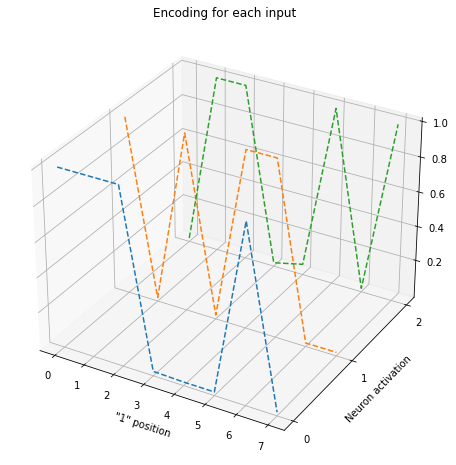

In [211]:
fig = plt.figure()
ax = fig.gca(projection="3d")
for i in range(3):
    ax.plot(
        np.arange(len(hidden_activation)),
        [i] * 8,
        [m[i] for m in hidden_activation],
        "--",
    )
plt.yticks(np.arange(3))
plt.ylabel("Neuron activation")
plt.xlabel('"1" position')
plt.title("Encoding for each input")
plt.show()

We can use this graph to inference the encoding the encoder and the decoder have agreed upon. For example, a low value in neuron 1, a high value in neuron 2 and 3 means "[1, 0, 0, 0, 0, 0, 0,0]". The most important part is that each *x* is uniquely mapped to a combination of those three neuron activation. The graph shows that this is indeed the case.
